In [95]:
# Purpose: Clean df and add alignments feature
# Authors: Noah
import pandas as pd
import numpy as np
import re

In [96]:
df = pd.read_csv('../Data/Novice.csv')

In [97]:
# Things to check alignment: Gender, Race, 

Adding 'Alignment Gender' column

In [98]:
df['Alignment Gender'] = df['Big Gender'] == df['Little Gender']

In [99]:
df['Alignment Gender']

0       True
1       True
2       True
3       True
4       True
        ... 
3270    True
3271    True
3272    True
3273    True
3274    True
Name: Alignment Gender, Length: 3275, dtype: bool

In [100]:
print(df['Alignment Gender'].sum())

3074


## Looking at data broadly - what is missing?

In [101]:
print("Initial Inspection:")
print(df.info())
print(df.head())
print("\nMissing values per column:")
print(df.isnull().sum())

Initial Inspection:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3275 entries, 0 to 3274
Data columns (total 67 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Match ID 18Char                                    3275 non-null   object 
 1   Stage                                              3275 non-null   object 
 2   Little ID                                          3275 non-null   object 
 3   Big ID                                             3275 non-null   object 
 4   Big County                                         2620 non-null   object 
 5   Big Age                                            3275 non-null   int64  
 6   Big Occupation                                     2950 non-null   object 
 7   Big: Military                                      1231 non-null   object 
 8   Big Approved Date                                  2984 non-null   o

<Axes: >

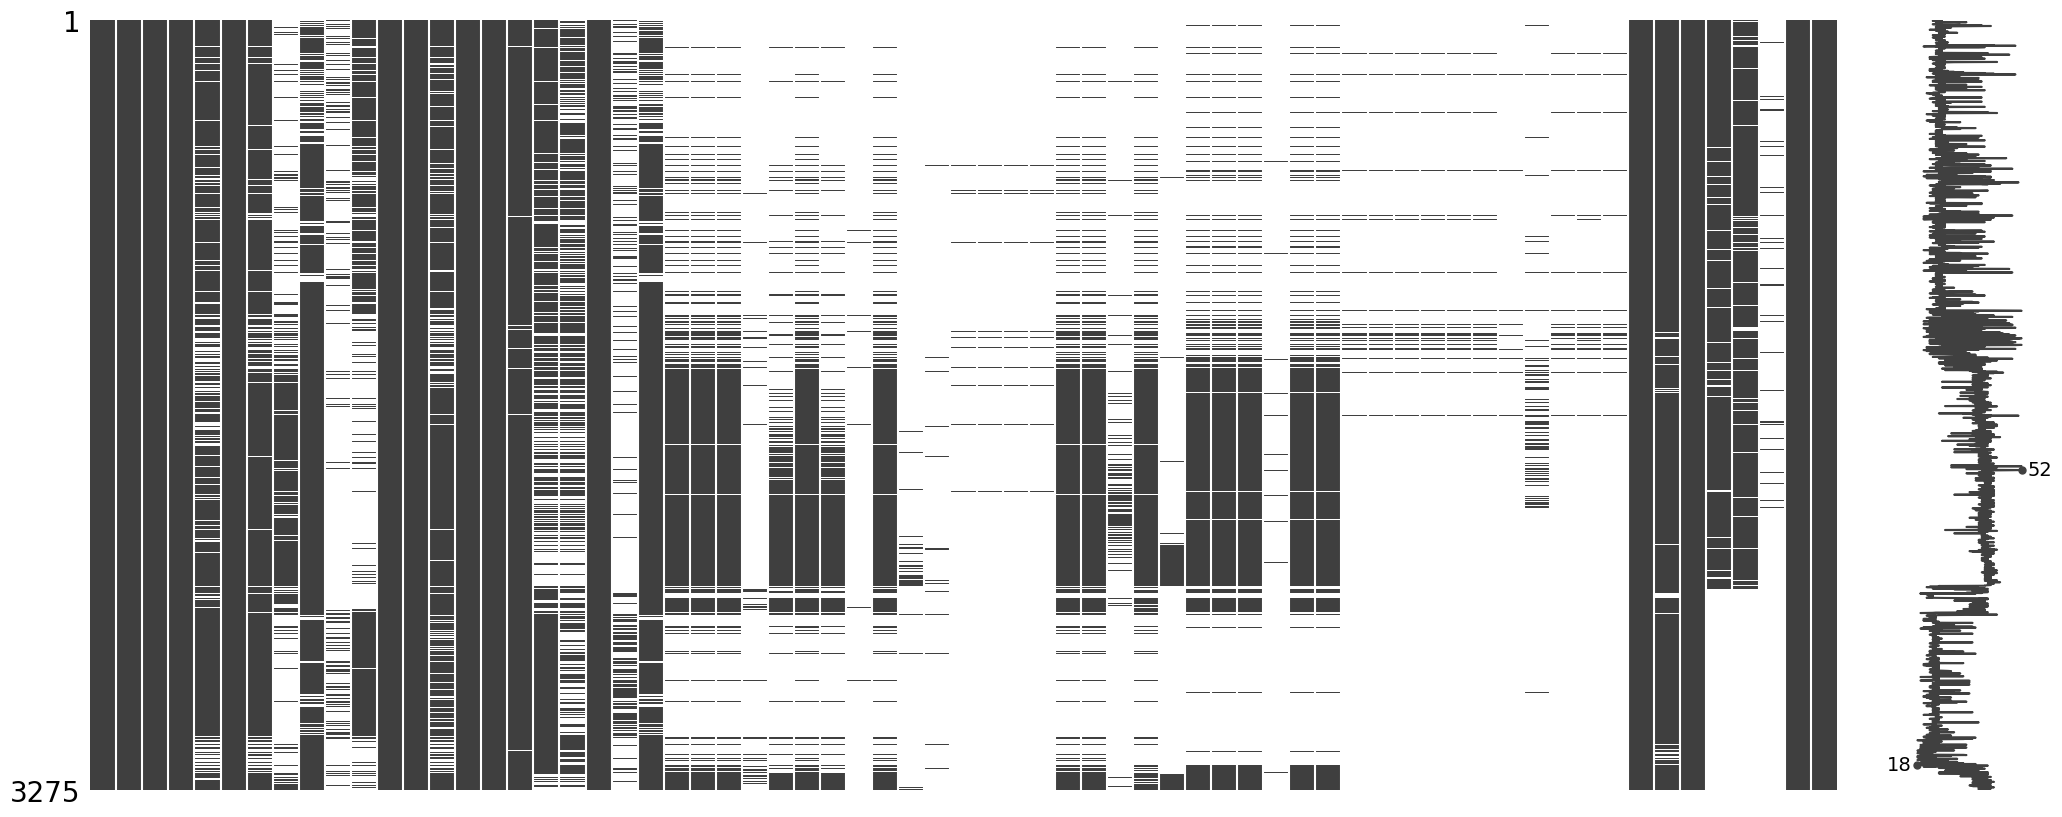

In [102]:
# Checking meaningfulness of missing values
import missingno as msno
msno.matrix(df)

In [103]:
def is_low_variance(column, threshold=0.1):
    if pd.api.types.is_numeric_dtype(column):
        return column.std() / column.mean() < threshold
    return False

In [104]:
# Identify columns with less than 5% missing values
missing_percentage = df.isnull().mean()
columns_less_than_5_percent_missing = missing_percentage[missing_percentage < 0.05].index.tolist()

# Impute missing values for columns with less than 5% missing values and low variance
for column in columns_less_than_5_percent_missing:
    if df[column].isnull().sum() > 0:  # Check if the column has missing values
        if pd.api.types.is_numeric_dtype(df[column]) and is_low_variance(df[column]):
            # Impute numerical columns with mean
            df[column].fillna(df[column].mean(), inplace=True)
        elif pd.api.types.is_categorical_dtype(df[column]) or pd.api.types.is_object_dtype(df[column]):
            # Impute categorical columns with mode
            df[column].fillna(df[column].mode()[0], inplace=True)

/var/folders/vj/7qqljyy57qxcbg0rt4wlqxqr0000gn/T/ipykernel_18007/1754024543.py:11: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(df[column]) or pd.api.types.is_object_dtype(df[column]):
/var/folders/vj/7qqljyy57qxcbg0rt4wlqxqr0000gn/T/ipykernel_18007/1754024543.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].mode()[0], inplace=True)


In [118]:
print("Inspection after Imputing Data with less than 5% missing:")
print(df.info())
print(df.head())
print("\nMissing values per column:")
print(df.isnull().sum())

Inspection after Imputing Data with less than 5% missing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3275 entries, 0 to 3274
Data columns (total 67 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Match ID 18Char                                    3275 non-null   object 
 1   Stage                                              3275 non-null   object 
 2   Little ID                                          3275 non-null   object 
 3   Big ID                                             3275 non-null   object 
 4   Big County                                         2620 non-null   object 
 5   Big Age                                            3275 non-null   int64  
 6   Big Occupation                                     2950 non-null   object 
 7   Big: Military                                      1231 non-null   object 
 8   Big Approved Date             

In [106]:
summary_stats = df['Big Days Acceptance to Match'].describe()
print("Summary Statistics for 'Big Days Acceptance to Match':") # there are negative numbers in here - how?
print(summary_stats)


Summary Statistics for 'Big Days Acceptance to Match':
count     864.000000
mean      113.488426
std       151.668060
min      -298.000000
25%        34.000000
50%        57.000000
75%       124.250000
max      1132.000000
Name: Big Days Acceptance to Match, dtype: float64


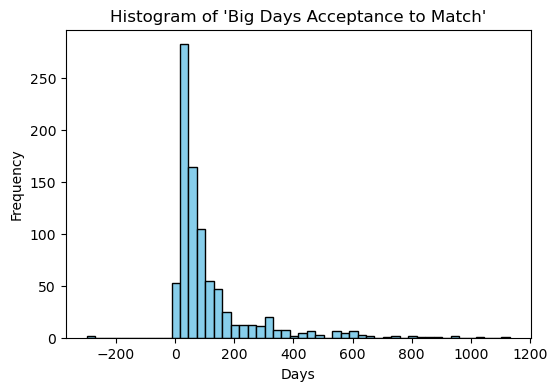

In [107]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.hist(df['Big Days Acceptance to Match'], bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of 'Big Days Acceptance to Match'")
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.show()

In [108]:
# Negative value seems to be an outlier
df_filtered = df[df['Big Days Acceptance to Match'] >= 0]

Trying a Regressor model to do predictive imputation on data based on other variables

In [141]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# Set a seed for reproducibility
np.random.seed(8080)

# Define features and target
features = [
    'Big Age',
    'Big Occupation', 
    'Program', 
    'Match Length',  
    'Match Activation Date', 
    'Big Gender',
    'Big Race/Ethnicity',
    'Big County',
    'Program Type',
    'Big Enrollment: Record Type',
    'Big Birthdate',
    'Big Approved Date',
    'Big Re-Enroll'
]
target = 'Big Days Acceptance to Match'

# Filter rows with and without missing values in the target column
df_missing = df[df[target].isnull()] # test
df_not_missing = df_filtered.dropna(subset=[target]) # training
 
# Check if there are missing values to impute
if not df_missing.empty and not df_not_missing.empty:
    # Separate features and target for rows without missing target values
    X = df_not_missing[features]
    y = df_not_missing[target]

    categorical_features = [
        'Big Occupation', 
        'Program', 
        'Big Gender', 
        'Big Race/Ethnicity', 
        'Big County', 
        'Program Type', 
        'Big Enrollment: Record Type',
        'Big Re-Enroll'
    ]
    
    date_features = [
        'Match Activation Date',
        'Big Birthdate',
        'Big Approved Date'
    ]
    
    numerical_features = [
        'Big Age',
        'Match Length'
    ]

    # Convert date features to numeric (e.g., days since a reference date)
    reference_date = pd.to_datetime('1940-01-01')  # Choose a reference date
    for date_col in date_features:
        X[date_col] = (pd.to_datetime(X[date_col]) - reference_date).dt.days
        df_missing[date_col] = (pd.to_datetime(df_missing[date_col]) - reference_date).dt.days

    # One-hot encode categorical features
        preprocessor = ColumnTransformer(
            transformers=[
                # For categorical features: impute missing values, then one-hot encode
                ('cat', Pipeline([
                    ('imputer', SimpleImputer(strategy='most_frequent')),
                    ('encoder', OneHotEncoder(handle_unknown='ignore'))
                ]), categorical_features),
                
                # For numerical features: impute missing values, then scale
                ('num', Pipeline([
                    ('imputer', SimpleImputer(strategy='median')),
                    ('scaler', StandardScaler())
                ]), numerical_features),
                
                # For date features: impute missing values, then scale
                ('date', Pipeline([
                    ('imputer', SimpleImputer(strategy='median')),
                    ('scaler', StandardScaler())
                ]), date_features)
            ],
            remainder='drop'  # Drop any columns not specified
        )

    # Create a pipeline with preprocessing and the RandomForestRegressor model
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor())
    ])

    # Define a parameter grid for GridSearchCV
    param_grid = {
        'regressor__n_estimators': [50, 100, 200],  # Number of trees in the forest
        'regressor__max_depth': [None, 10, 20],  # Maximum depth of the tree
        'regressor__min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
        'regressor__min_samples_leaf': [1, 2, 4]  # Minimum samples required at a leaf node
    }

    # Set up K-Fold Cross-Validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Perform GridSearchCV with K-Fold Cross-Validation
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=kfold,
        scoring='neg_mean_absolute_error',  # Use MAE as the scoring metric
        n_jobs=-1  # Use all available CPU cores
    )

    # Train the model using GridSearchCV
    grid_search.fit(X, y)

    # Print the best parameters and best score
    print("Best Parameters:", grid_search.best_params_)
    print("Best MAE Score:", -grid_search.best_score_)  # Convert back to positive MAE

    # Evaluate the model on the validation set
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_val)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)

    print(f"Validation Metrics:\n"
          f"Mean Absolute Error (MAE): {mae:.2f}\n"
          f"Mean Squared Error (MSE): {mse:.2f}\n"
          f"Root Mean Squared Error (RMSE): {rmse:.2f}\n"
          f"R-squared (R2): {r2:.2f}")

    # Predict missing values
    X_test = df_missing[features]
    df_missing[target] = best_model.predict(X_test)

    # Combine the dataframes to get the final dataset with imputed values
    df_imputed = pd.concat([df_not_missing, df_missing])

    # Reset index if necessary
    df_imputed.reset_index(drop=True, inplace=True)

    # Save the imputed dataset to a new CSV file
    df_imputed.to_csv('Novice_Imputed.csv', index=False)

    print("Missing values have been imputed and the dataset is saved as 'Novice_Imputed.csv'.")
else:
    print("No missing values to impute or insufficient data for modeling.")

/var/folders/vj/7qqljyy57qxcbg0rt4wlqxqr0000gn/T/ipykernel_18007/1235422068.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[date_col] = (pd.to_datetime(X[date_col]) - reference_date).dt.days
/var/folders/vj/7qqljyy57qxcbg0rt4wlqxqr0000gn/T/ipykernel_18007/1235422068.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_missing[date_col] = (pd.to_datetime(df_missing[date_col]) - reference_date).dt.days
/var/folders/vj/7qqljyy57qxcbg0rt4wlqxqr0000gn/T/ipykernel_18007/1235422068.py:66: SettingWithCopy

Best Parameters: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 100}
Best MAE Score: 63.007012602686075
Validation Metrics:
Mean Absolute Error (MAE): 41.74
Mean Squared Error (MSE): 4100.82
Root Mean Squared Error (RMSE): 64.04
R-squared (R2): 0.82
Missing values have been imputed and the dataset is saved as 'Novice_Imputed.csv'.


/var/folders/vj/7qqljyy57qxcbg0rt4wlqxqr0000gn/T/ipykernel_18007/1235422068.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_missing[target] = best_model.predict(X_test)


In [110]:
X_test['Preds'] = X_preds
X_test

/var/folders/vj/7qqljyy57qxcbg0rt4wlqxqr0000gn/T/ipykernel_18007/3510808567.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Preds'] = X_preds


Big Age                Big Occupation                       Program  \
0          40                    Unemployed             General Community   
1          65         Tech: Research/Design             General Community   
2          45                      Military             General Community   
3          61              Finance: Banking             General Community   
4          29    Human Services: Non-Profit             General Community   
...       ...                           ...                           ...   
3202       31                       Finance             BSW-General Mills   
3203       39                           NaN  Grad Coach-Henry High School   
3205       43  Human Services: Youth Worker                  General Site   
3252       37                Govt: Clerical          School-Based Program   
3254       50           Law: Police Officer          School-Based Program   

      Match Length  Match Activation Date   Preds  
0              9.0                   6271   99.36  
1             46.1                   6676   39.30  
2              6.2                   6291  102.46  
3             85.6                   6585   60.87  
4             28.3                   6677   77.15  
...            ...                    ...     ...  
3202           6.6                   7655  771.28  
3203           8.1                   7401  154.54  
3205          19.1                   7409  180.78  
3252          11.0                   8853   47.25  
3254          12.4                   8810   36.58  

[2411 rows x 6 columns]

In [111]:
summary_stats = {
    "Count": X_preds.size,
    "Mean": np.mean(X_preds),
    "Std Dev": np.std(X_preds, ddof=1),  # Use ddof=1 for sample standard deviation
    "Min": np.min(X_preds),
    "25th Percentile (Q1)": np.percentile(X_preds, 25),
    "Median (Q2)": np.median(X_preds),
    "75th Percentile (Q3)": np.percentile(X_preds, 75),
    "Max": np.max(X_preds),
}

# Print results
for stat, value in summary_stats.items():
    print(f"{stat}: {value:.2f}")

Count: 2411.00
Mean: 204.45
Std Dev: 246.38
Min: 26.96
25th Percentile (Q1): 78.94
Median (Q2): 95.80
75th Percentile (Q3): 118.84
Max: 913.43


In [112]:
#df.to_csv('your_file.csv', index=False)

## More Alignments

In [113]:
df['Big Contact: Interest Finder - Sports']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
3270    NaN
3271    NaN
3272    NaN
3273    NaN
3274    NaN
Name: Big Contact: Interest Finder - Sports, Length: 3275, dtype: object

In [114]:
filtered_df = df.dropna(subset=['Big Contact: Interest Finder - Sports'])
filtered_df['Big Contact: Interest Finder - Sports']

9       Bowling; Frisbee; Golf/mini golf; Hockey; Ping...
262                                               Bowling
599     Basketball; Frisbee; Rollerskating/blading; Te...
618           Bowling; Frisbee; Golf/mini golf; Ping Pong
636              Bowling; Rollerskating/blading; Swimming
725     Basketball; Bowling; Football; Frisbee; Golf/m...
726     Basketball; Bowling; Football; Frisbee; Golf/m...
737                                        Hockey; Tennis
946     Bowling; Frisbee; Golf/mini golf; Ping Pong; S...
1172    Bowling; Golf/mini golf; Rollerskating/blading...
1324    Baseball/Softball; Basketball; Bowling; Golf/m...
1350    Bowling; Football; Frisbee; Golf/mini golf; Ma...
1381                                           None/Other
1389    Bowling; Frisbee; Golf/mini golf; Ping Pong; R...
1392       Baseball/Softball; Bowling; Frisbee; Ping Pong
1423    Basketball; Bowling; Football; Rollerskating/b...
1447    Baseball/Softball; Bowling; Golf/mini golf; Gy...
1478    Baseba

In [115]:
df['Little Contact: Interest Finder - Sports']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
3270    NaN
3271    NaN
3272    NaN
3273    NaN
3274    NaN
Name: Little Contact: Interest Finder - Sports, Length: 3275, dtype: object

In [116]:
filtered_df = df.dropna(subset=['Little Contact: Interest Finder - Sports'])
filtered_df['Little Contact: Interest Finder - Sports']

107     Baseball/Softball; Basketball; Bowling; Gymnas...
109     Baseball/Softball; Basketball; Bowling; Gymnas...
142                                              Swimming
145                                              Swimming
147                                              Swimming
                              ...                        
1682             Bowling; Football; Rollerskating/blading
1891    Basketball; Football; Frisbee; Golf/mini golf;...
1897    Baseball/Softball; Basketball; Bowling; Footba...
1913    Basketball; Bowling; Frisbee; Golf/mini golf; ...
1914    Basketball; Bowling; Frisbee; Golf/mini golf; ...
Name: Little Contact: Interest Finder - Sports, Length: 80, dtype: object